## Röntgen Resimlerinden COVID-19 Tahmini

Birden çok veri kaynağından toplanan . Veri kaynaklarının özetine https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md adresinden ulaşılabilir. Bu çalıştay için resimler küçültüldü ve eğitim ve test kümeleri sınıf oranlarını korumak için bir miktar değiştirildi.

Bu çalıştayda göğüs röntgen resimlerinden, normal, covid olmaya zatürre ve covid-19 tespiti çalışması yapılacaktır. Tahmin için Evrişimsel Sinir Ağları (Convolutional Neural Network) yaratılacak ve eğitilecektir. Kullanılan resimler bir çok veri kaynağından toplanmıştır. Veri kaynaklarının özetine https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md adresinden ulaşılabilir. Bu çalıştay için resimler küçültülmüş ve eğitim ve test kümeleri sınıf oranlarını korumak için bir miktar değiştirilmiştir.

In [1]:
# Gereken kütüphaneler
import os, glob, time, random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as Layers

In [2]:
# Genel olarak yardımcı fonksiyonlar
def setupMatplotLib():
    plt.rc('figure', figsize=(10,7))
    plt.rc('font', size=14)
    plt.rc('axes', titlesize=18)     # fontsize of the axes title
    plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
    plt.rc('legend', fontsize=12)    # legend fontsize
    plt.rc('figure', titlesize=20)   # fontsize of the figure title
setupMatplotLib()

def plot_history(histories, vertical=False, otherkey='accuracy'):
    plt.rc('figure', figsize=(14,8))
    if vertical:
        p,r = 2,1
    else:
        p,r = 1,2 
    anyPlots = False
    k=1
    for name, history in histories:
        if 'val_loss' in history.history.keys():
            anyPlots = True
            
            ax = plt.subplot(p,r,1)
            val = ax.plot(history.epoch, history.history['val_loss'],
                           '--', label=name.title()+' Val')
            ax.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
                     label=name.title()+' Train')
        elif 'loss' in history.history.keys():
            anyPlots = True
            
            ax = plt.subplot(p,r,1)
            ax.plot(history.epoch, history.history['loss'], label=name.title()+' Train')
            
        if 'val_' + otherkey in history.history.keys():
            k = 2
            anyPlots = True
            
            ax = plt.subplot(p,r,2)
            val = ax.plot(history.epoch, history.history['val_' + otherkey],
                           '--', label=name.title()+' Val')
            ax.plot(history.epoch, history.history[otherkey], color=val[0].get_color(),
                     label=name.title()+' Train')
        elif otherkey in history.history.keys():
            k = 2
            anyPlots = True
            
            ax = plt.subplot(p,r,2)
            ax.plot(history.epoch, history.history[otherkey], label=name.title()+' Train')
        plt.rc('figure', figsize=(10,7))

    if anyPlots:
        for i in range(1,k+1):
            if i == 1:
                key = histories[0][1].model.loss
            else:
                key = otherkey
            ax = plt.subplot(p,r,i)
            ax.set_xlabel('Epochs')
            ax.set_ylabel(key.replace('_',' ').title())
            ax.legend()
        plt.tight_layout()
        
def plotClassCounts(countDict):
    plt.figure(figsize=(12,8))
    plt.bar(range(len(countDict)), countDict.values())
    plt.xticks(range(len(countDict)),countDict.keys())
    plt.ylabel('Sayılar')
    plt.xlabel('Sınıflar')

# Klasördeki bütün dosyalar ersim diye varsayıyoruz
def plotRandomImages(path):
    classNames = ['COVID-19','normal','pneumonia']
    images = []
    for i, cn in enumerate(classNames):
        imageNames = imagesC19 = os.listdir(os.path.join(path,cn))
        filepath = random.choice(imageNames)
        images.append(Image.open(os.path.join(path,cn,filepath)))
    plt.figure(figsize=(18,6))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary_r)
        plt.xlabel(classNames[i])
    plt.show()

In [3]:
# Eğitim ve validasyıon kümesi aynı rassal çekirdek ile başlaması için
seed = int(time.time())

# Elimizdeki resimler 256x256. Eğitim biraz daha hızlı olsun diye 128x128 olarak eğitiyoruz
imsize = (128, 128)

# Veriyi değişik dönüşümler ile değiştirip değiştirmeyeceğimiz
# Genelde veri az ise bu işe yarar ancak bu problem için şart değil gibi gözüküyor
augment = False 

datadir = 'data'

if augment:
    
    # Hafızaya sığacak kadar seçiyoruz, sizin kullandığınız yerde farklı seçmek gerekebilir
    batch_size = 256
    
    traingGen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=3,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rescale=1/255.,
        validation_split=0.2,
        dtype='float16'
    )
    
    testGen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.,
        dtype='float16'
    ) 
    
    trainData = traingGen.flow_from_directory(
        directory = os.path.join(datadir, 'train'),
        color_mode="grayscale",
        batch_size=batch_size,
        target_size=imsize,
        shuffle=True,
        subset='training',
        seed = seed,
        class_mode="sparse"
    )
    
    valData = traingGen.flow_from_directory(
        directory = os.path.join(datadir, 'train'),
        color_mode="grayscale",
        batch_size=batch_size,
        target_size=imsize,
        shuffle=True,
        subset='validation',
        seed = seed,
        class_mode="sparse"
    )
    
    testData = testGen.flow_from_directory(
        directory = os.path.join(datadir, 'test'),
        color_mode="grayscale",
        batch_size=batch_size,
        target_size=imsize,
        class_mode="sparse",
        shuffle = False
    )
    
else:
    
    # Hafızaya sığacak kadar seçiyoruz, sizin kullandığınız yerde farklı seçmek gerekebilir
    batch_size = 128
    
    trainData = tf.keras.preprocessing.image_dataset_from_directory(
        directory = os.path.join(datadir, 'train'),
        color_mode="grayscale",
        batch_size=batch_size,
        image_size=imsize,
        shuffle=True,
        validation_split=0.2,
        subset='training',
        seed = seed
    )

    valData = tf.keras.preprocessing.image_dataset_from_directory(
        directory = os.path.join(datadir, 'train'),
        color_mode="grayscale",
        batch_size=batch_size,
        image_size=imsize,
        shuffle=True,
        validation_split=0.2,
        subset='validation',
        seed = seed
    )

    testData = tf.keras.preprocessing.image_dataset_from_directory(
        directory = os.path.join(datadir, 'test'),
        color_mode="grayscale",
        batch_size=batch_size,
        image_size=imsize,
        shuffle = False
    )

Found 15077 files belonging to 3 classes.
Using 12062 files for training.
Found 15077 files belonging to 3 classes.
Using 3015 files for validation.
Found 1692 files belonging to 3 classes.


In [4]:
# Sınıf sayılarına bakalım

# veriden saymak isteseydik ama sayırları bildiğimiz için geçiyoruz
#if augment:
#    yTrain = trainData.classes
#    yTest  = testData.classes
#else:
#    yTrain = np.concatenate([y for x, y in trainData], axis=0)
#    yTest  = np.concatenate([y for x, y in testData], axis=0)

# Eğitim ve test kümeleri veriden 90-10 olarak ayrıldı. Eğitirken %90'nın %20'sini de validasyon olarak ayıracağız.
counts = {'train':{'COVID-19':1593,'normal':7966,'pneumonia':5462},
          'test': {'COVID-19':177, 'normal': 885,'pneumonia': 607}}

# Sınıf oranları, görüleceği üzere eşit değiller
train_ratios = np.array(list(counts['train'].values()))/sum(counts['train'].values())

print('Sınıf oranları:',train_ratios)

Sınıf oranları: [0.10605153 0.53032421 0.36362426]


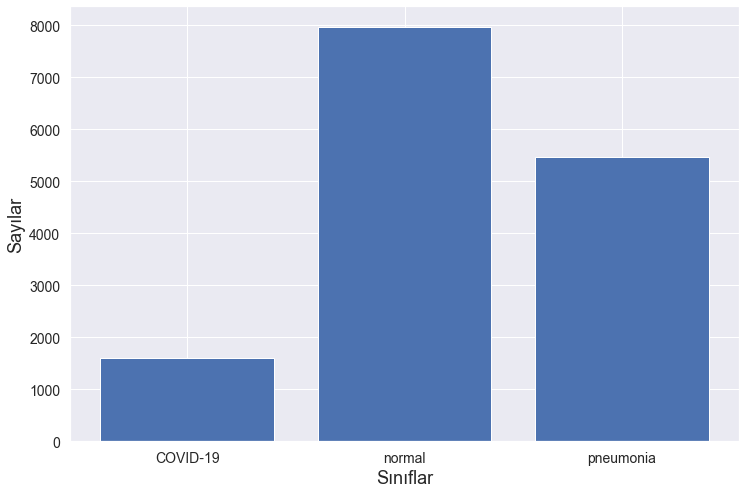

In [5]:
plotClassCounts(counts['train'])

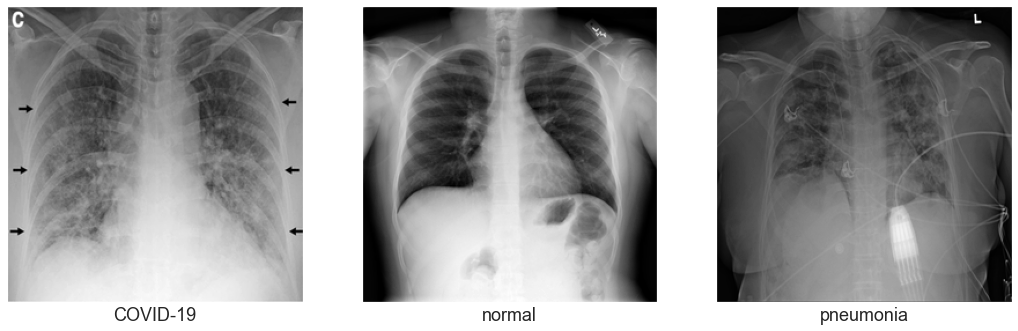

In [6]:
# Rastgele örneklere bakalım
plotRandomImages('data/train')

Artık sıra modeli kurmaya geldi. Başlangıç için çok ufak bir model veriyoruz ancak bu yeterli değil

In [7]:
def baseCnnClassifier(optimizer='adam'):
    model = Sequential()
    
    # Tipik bir evrişimsel grup
    model.add(Layers.Conv2D(filters = 16, kernel_size=(5,5), strides = 1, padding='same'))
    model.add(Layers.Activation('relu'))
    model.add(Layers.Conv2D(filters = 16, kernel_size=(5,5), strides = 1, padding='same'))
    model.add(Layers.Activation('relu')) 
    model.add(Layers.BatchNormalization()) 
    model.add(Layers.MaxPool2D(pool_size=(2,2),strides=2))
    
    model.add(Layers.Conv2D(filters=32,kernel_size=(3,3), strides = 1, padding='same'))
    model.add(Layers.Activation('relu'))
    model.add(Layers.Conv2D(filters=32,kernel_size=(3,3), strides = 1, padding='same'))
    model.add(Layers.Activation('relu'))
    model.add(Layers.BatchNormalization())
    model.add(Layers.MaxPool2D(pool_size=(2,2),strides=2))
    
    # Çıktı katmanına bağlamak için düzleştiriyoruz
    model.add(Layers.GlobalAveragePooling2D())
    
    model.add(Layers.Dense(3,activation='softmax', dtype='float32'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [8]:
# Modeli yaratalım
baseModel = baseCnnClassifier(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

# Aşırı-uyum yaptığı durumda erkenden bitirmek için
earlyStop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Validasyon kümemize göre performansu en iyi olan modeli kaydedelim
modelSave = keras.callbacks.ModelCheckpoint('./checkpoint',monitor='val_accuracy', 
                                            save_best_only=True, save_weights_only=True,
                                            mode='max',)
epochs = 20

baseHist = baseModel.fit(trainData,
                         epochs = epochs, verbose = 1,
                         # Validasyon verisine göre model seçip eğitimi durduracağız
                         validation_data=valData,
                         callbacks = [earlyStop, modelSave],                         
                         # Sınıf oranları eşit değildi, COVID arada kaynamasın diye onun ağırlığını arttırıyoruz
                         class_weight = {0: 4, 1: 1, 2: 1}
                        )

baseModel.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
95/95 [==============================] - 355s 4s/step - loss: 1.1424 - accuracy: 0.6113 - val_loss: 0.9832 - val_accuracy: 0.5240
Epoch 2/20
95/95 [==============================] - 358s 4s/step - loss: 0.9369 - accuracy: 0.7263 - val_loss: 0.7772 - val_accuracy: 0.7284
Epoch 3/20
95/95 [==============================] - 270s 3s/step - loss: 0.8243 - accuracy: 0.7639 - val_loss: 0.7468 - val_accuracy: 0.7436
Epoch 4/20
95/95 [==============================] - 357s 4s/step - loss: 0.7433 - accuracy: 0.7886 - val_loss: 0.8585 - val_accuracy: 0.6279
Epoch 5/20
95/95 [==============================] - 359s 4s/step - loss: 0.6953 - accuracy: 0.7967 - val_loss: 0.8703 - val_accuracy: 0.6249
Epoch 6/20
95/95 [==============================] - 360s 4s/step - loss: 0.6459 - accuracy: 0.8138 - val_loss: 4.9832 - val_accuracy: 0.1602
Epoch 7/20
95/95

<ipython-input-2-e1953f3e293a>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(p,r,i)


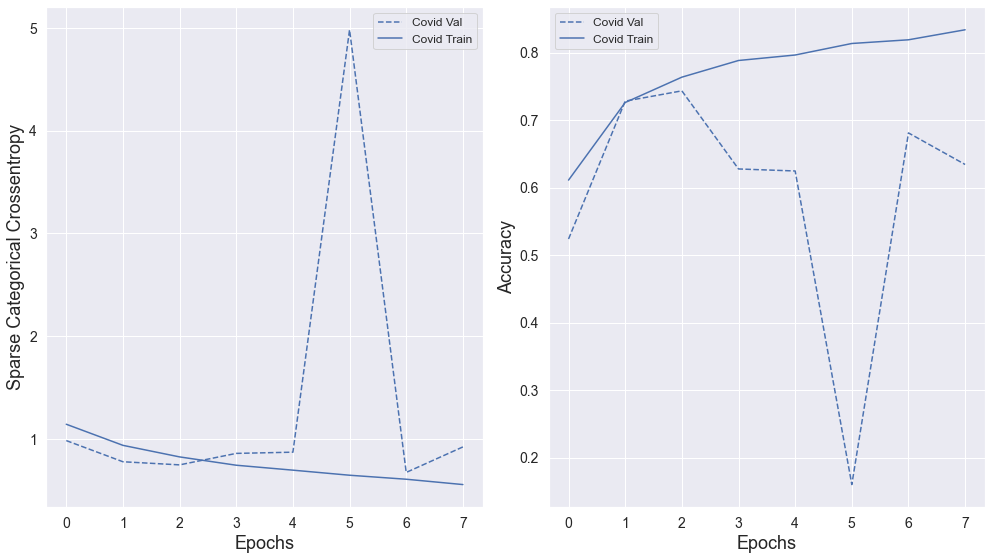

In [9]:
plot_history([('COVID',baseHist)]) 

In [10]:
# En iyi validasyon sonucunu veren ağırlıkları yüklüyoruz
baseModel.load_weights('./checkpoint')
#print('Eğitim performansı', baseModel.evaluate(trainData))

# Eğitimde ve model seçiminde kullanmadığımız bir küme ile test ediyoruz
print('Test performansı', baseModel.evaluate(testData))

14/14 [==============================] - 9s 655ms/step - loss: 0.7540 - accuracy: 0.7394
Test performansı [0.754033088684082, 0.7393617033958435]


Sonuçlara biraz daha detaylı bakalım

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
ypred = np.argmax(baseModel.predict(testData), axis=-1)
if augment:
    ytrue = testData.classes
else:
    ytrue = np.concatenate([y for x, y in testData], axis=0)
print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

           0       0.50      0.45      0.48       177
           1       0.85      0.74      0.79       885
           2       0.68      0.83      0.74       630

    accuracy                           0.74      1692
   macro avg       0.68      0.67      0.67      1692
weighted avg       0.75      0.74      0.74      1692



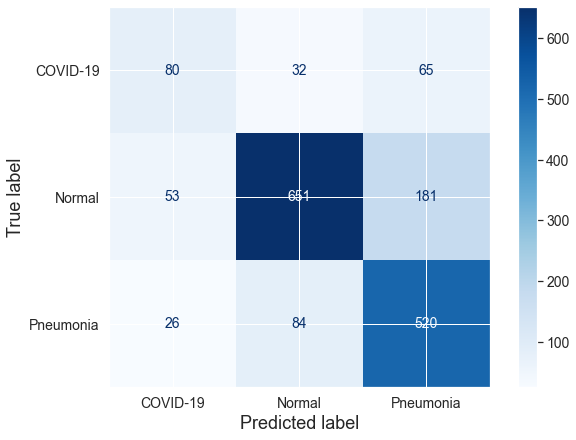

In [12]:
cm = confusion_matrix(ytrue, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID-19','Normal','Pneumonia'])
disp.plot(cmap='Blues')

Buradan nereye gidebilirsiniz:
* Daha ileri mimariler (bu problem için örnek: https://arxiv.org/abs/2003.09871)
* Tıbbi görüntülerde bölütleme (segmentasyon)
* Başka tıbbi görüntüler (örn: göğüs tomografisi)